#Data Preparation for clinical dataset

In [0]:
#Assign variable name to each file name to make the code reuseable

clinicaltrial = "clinicaltrial_2021"
pharma = "pharma"
completionyear = '2021'

In [0]:
#Check that the file has successfully been imported to DBFS filestore

dbutils.fs.ls("/FileStore/tables/")

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/FaultDataset.csv', name='FaultDataset.csv', size=1703184, modificationTime=1681337703000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1677679899000),
 FileInfo(path='dbfs:/FileStore/tables/TS021_2021_2.csv', name='TS021_2021_2.csv', size=497239, modificationTime=1679498317000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1675269708000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019.zip', name='clinicaltrial_2019.zip', size=9707871, modificationTime=1678984730000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020.csv', name='clinicaltrial_2020.csv', size=463

In [0]:
#Copy the file zipped file from DBFS file store to the tmp folder
dbutils.fs.cp("/FileStore/tables/" + clinicaltrial + ".zip", "file:/tmp", True)

#Allow interaction with the os
import os
os.environ['clinicaltrial'] = clinicaltrial

In [0]:
%sh
unzip -d/tmp /tmp/$clinicaltrial.zip

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  


In [0]:
#Move unzipped file to DBFS folder
dbutils.fs.mv("file:/tmp/" + clinicaltrial + ".csv", "/FileStore/tables/" , True)

#Read csv file from DBFS File store to RDD
clinicaltrial_rdd = sc.textFile("/FileStore/tables/" + clinicaltrial + ".csv")

#Preview the first 10 rows of the dataset
clinicaltrial_rdd.take(10)

Out[5]: ['Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions',
 'NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|',
 'NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate',
 'NCT02752438|Ankara University|Unknown status|May 2016|Jul 2

In [0]:
#Assign variable name to file header
clinicaltrial_rdd_header = clinicaltrial_rdd.first()

#Filter out the file header using the assigned variable name
clinicaltrial_rdd = clinicaltrial_rdd.filter(lambda x: x != clinicaltrial_rdd_header)

#Split dataset by the delimeter 
clinicaltrial_rdd = clinicaltrial_rdd.map(lambda x: x.split("|"))


#Question 1 - Pyspark RDD

In [0]:
#select distinct values from the first element of each tuple and count

NumberOfDistinctStudies = clinicaltrial_rdd.map(lambda x: x[0]).distinct().count()
print(NumberOfDistinctStudies)

387261


#Question 2 - Pyspark RDD

In [0]:
#Select the required column and assign a key value pair
TypesOfStudies = clinicaltrial_rdd.map(lambda x: (x[5], 1))

#Aggregate the values of each element in the selected column
FrequencyOfStudyType = TypesOfStudies.reduceByKey(lambda a, b: a + b)

#Sort by the aggregated values in descending order
SortedFrequency = FrequencyOfStudyType.sortBy(lambda x: x[1], False)

#Show the result
SortedFrequency.collect()

Out[8]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

#Question 3 - Pyspark RDD

In [0]:
#Select the required column and filter out the null fields
Conditions = clinicaltrial_rdd.map(lambda x: (x[7])).filter(lambda x: x != '')

#Transform and split the RDD using the delimeter , 
Conditions1 = Conditions.flatMap(lambda x: x.split(','))

#Assign a key value pair
Conditions2 = Conditions1.map(lambda x: (x, 1))

#Count the values and group by the selected column
TheConditionsFrequency = Conditions2.reduceByKey(lambda a, b: a + b)

#Sort the result in descending order
SortedConditionsByFrequency = TheConditionsFrequency.sortBy(lambda x: x[1], False)

#Show top five conditions sorted by the frequency
SortedConditionsByFrequency.take(5)

Out[9]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

#Data Preparation for pharma dataset

In [0]:
#Copy the zipped pharma file from DBFS file store to tmp folder
dbutils.fs.cp("/FileStore/tables/" + pharma + ".zip", "file:/tmp", True)

#Allow interaction with the os
import os
os.environ['pharma'] = pharma

In [0]:
%sh
unzip -d/tmp /tmp/$pharma.zip

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
#Move unzipped file to the DBFS filestore
dbutils.fs.mv("file:/tmp/" + pharma + ".csv", "/FileStore/tables/", True)

#Create RDD by reading the data from the pharma csv file to the RDD
pharma_rdd = sc.textFile("/FileStore/tables/" + pharma + ".csv")

#Preview the first 10 rows of the dataset
pharma_rdd.take(10)

Out[12]: ['"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"',
 '"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the c

In [0]:
#Assign header to variable name
pharma_rdd_header = pharma_rdd.first()

#Filter out header
pharma_rdd = pharma_rdd.filter(lambda x: x != pharma_rdd_header)



#Question 4 - Pyspark RDD

In [0]:
#Split pharma dataset using delimiter "," and assign second column to a new RDD
Pharmaceuticals_rdd = pharma_rdd.map(lambda x: x.split('","')[1])

#Assign second column of the clinical trial dataset to a new RDD
Sponsor_rdd = clinicaltrial_rdd.map(lambda x: x[1])

#Assign key value pair and count by each sponsor
Sponsor_rdd= Sponsor_rdd.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)

#Retrieve Pharmaceuticals RDD into a list
Pharmaceuticals = Pharmaceuticals_rdd.collect()

#Filter out sponsors not in Pharmaceuticals and sort in descending order by the count
sponsor_freq = Sponsor_rdd.filter(lambda x: x[0] not in Pharmaceuticals).sortBy(lambda x:x[1], False)

#Show the top 10 records
sponsor_freq.take(10)

Out[14]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

#Question 5 - Pyspark RDD

In [0]:
#Select the necessary columns and filter by completed and required year
completed_months = clinicaltrial_rdd.map(lambda x: (x[0], x[2], x[4])).filter(lambda x: x[1] == 'Completed' and x[2][-4:] == completionyear)# and x[2] != '')

#Select only the months from the filtered RDD and assign to a new RDD
completed_months = completed_months.map(lambda x: x[2][:3])


In [0]:
#Create a key value pair of the completed_months
completed_months2 = completed_months.map(lambda x: (x, 1))

#Aggregate the values of each element in the selected column
completed_months3=completed_months2.reduceByKey(lambda a, b: a + b)

# define a dictionary for months
MonthsDictionary = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
              'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

#Sort the result by the month
CompletedTrialsPerMonth = completed_months3.sortBy(lambda x: MonthsDictionary[x[0][:3]])

#Show result
CompletedTrialsPerMonth.collect()

Out[16]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

#Further Analysis

Examine the various reasons uncompleted trials remain unfinished

In [0]:
import matplotlib.pyplot as plt

#Filter the uncompleted trial status into an RDD
uncompleted_rdd = clinicaltrial_rdd.filter(lambda x: x[2] != 'Completed'  and x[2] != '')

#Create a new RDD with the status column, assign a key value pair, aggregate the value by the key and sort
uncompleted_rdd1= uncompleted_rdd.map(lambda x: x[2]).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1])

#Retrieve all elements of the rdd
uncompleted_rdd1.collect()

Out[19]: [('Temporarily not available', 1),
 ('Available', 5),
 ('Approved for marketing', 24),
 ('No longer available', 39),
 ('Suspended', 1598),
 ('Enrolling by invitation', 3682),
 ('Withdrawn', 9973),
 ('Not yet recruiting', 16499),
 ('Active, not recruiting', 17848),
 ('Terminated', 22285),
 ('Unknown status', 44608),
 ('Recruiting', 60950)]

In [0]:
import pandas as pd

#convert the RDD to DataFrame
uncompleted_DF = uncompleted_rdd1.toDF(['Status', 'Count'])

#convert the DataFrame to a pandas DataFrame for plotting
uncompleted_DF1 = uncompleted_DF.toPandas()

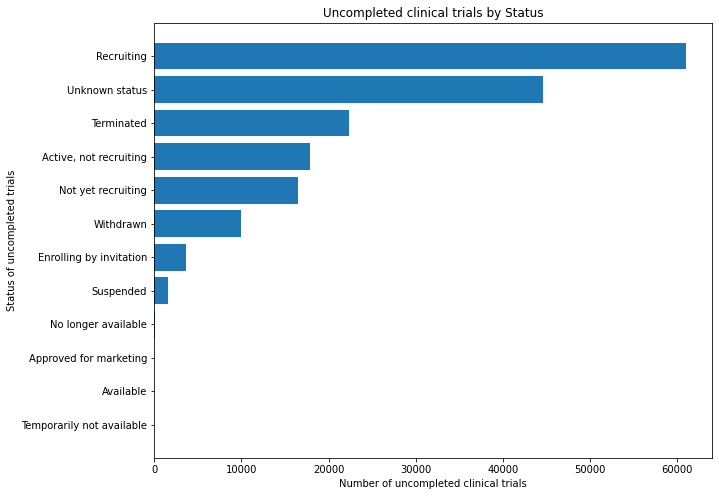

In [0]:
#plot a horizontal barplot 
plt.figure(figsize=(10,8))
plt.barh(uncompleted_DF1['Status'], uncompleted_DF1['Count'])
plt.xlabel('Number of uncompleted clinical trials')
plt.ylabel('Status of uncompleted trials')
plt.title('Uncompleted clinical trials by Status')
plt.show()